In [3]:
pip install praw transformers torch nltk pandas

Note: you may need to restart the kernel to use updated packages.


In [77]:
import praw

CLIENT_ID = "hqaCVwtwAhXvlDjWcvQozg"
CLIENT_SECRET = "0c08O3qbbN4teNz-gpxF5xYzZKxG1A"
USER_AGENT = "ucf-sentiment-app by u/fln___"

reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

def fetch_comments(sub="UCF", limit=10):
    subreddit = reddit.subreddit(sub)
    return [c.body for c in subreddit.comments(limit=limit)]

# Test: print 10 recent comments from r/UCF
comments = fetch_comments("UCF", 10)
for c in comments:
    print("-", c.replace("\n", " ")[:200])


- Sorry that was me, had too much taco bell
- "I'm tired, boss" -the hat, probably
- I believe I have him too, and I think all you can really do is just read the textbook for every lecture(get a pdf if possible) and do the homework sets in their entirety.
- It's 2025, but there's no video of this shit? If somebody was jacking off in my fucking window, I'd take video that shit and send it right to the cops, then the lawyer.
- I'm going to be honest it's in cursive and from what I have looked at and been able to read I don't think there's any personal information. Or from what I did read it looks like it gets heavily into t
- She commented back to someone saying “what will the police do?” 🥸 like girl go to the police
- I’ll take a look at it for you. The big guy upstairs just gave me permission
- What professor? I saw the video and kinda didn’t like believe it because UCF fires ppl so fast.
- The performative male contest
- Well, I get that you are hungry, but you should consider yoursel

In [79]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [51]:
import os, time
import pandas as pd
from datetime import datetime

# ----------------- Config -----------------
SUBREDDIT   = "UCF"
POST_SOURCE = "top"       # "top", "new", or "hot"
TIME_FILTER = "all"       # only used when POST_SOURCE == "top"  -> "day","week","month","year","all"
POST_LIMIT  = 1000         # how many posts to crawl this run (bump to 500/1000 later)
MASTER_CSV  = "ucf_sentiment_master.csv"
# ------------------------------------------

# load existing comment IDs to avoid duplicates
seen = set()
if os.path.exists(MASTER_CSV):
    try:
        prev = pd.read_csv(MASTER_CSV, usecols=["comment_id"])
        seen = set(prev["comment_id"].astype(str))
        print(f"Loaded {len(seen)} existing comment_ids from {MASTER_CSV}")
    except Exception as e:
        print("Note: couldn't read existing master file:", e)

rows = []
sub = reddit.subreddit(SUBREDDIT)

# choose post iterator
if POST_SOURCE == "top":
    post_iter = sub.top(time_filter=TIME_FILTER, limit=POST_LIMIT)
elif POST_SOURCE == "new":
    post_iter = sub.new(limit=POST_LIMIT)
else:
    post_iter = sub.hot(limit=POST_LIMIT)

processed_posts = 0
new_comments = 0

for post in post_iter:
    try:
        post.comments.replace_more(limit=None)  # pull ALL comments in the thread
        for c in post.comments.list():
            cid = str(c.id)
            if cid in seen:
                continue
            text = (c.body or "").strip()
            if not text:
                continue

            out = classifier(text[:512], truncation=True)[0]
            lab = out["label"].lower()
            if lab.startswith("label_"):
                lab = {"label_0":"negative","label_1":"neutral","label_2":"positive"}[lab]

            rows.append({
                "submission_id": post.id,
                "submission_title": post.title,
                "comment_id": cid,
                "text": text,
                "label": lab,
                "score": float(out["score"]),
                "comment_created_utc": int(c.created_utc)
            })
            new_comments += 1

        processed_posts += 1
        if processed_posts % 10 == 0:
            print(f"Processed posts: {processed_posts} | New comments this run: {new_comments}")
            # light pause to be nice to the API
            time.sleep(1)

    except Exception as e:
        print(f"Skipping post {post.id}: {e}")

# append to master CSV
if rows:
    df_new = pd.DataFrame(rows).drop_duplicates(subset=["comment_id"])
    if os.path.exists(MASTER_CSV):
        master = pd.read_csv(MASTER_CSV)
        master = pd.concat([master, df_new], ignore_index=True).drop_duplicates(subset=["comment_id"])
        master.to_csv(MASTER_CSV, index=False)
        print(f"Appended {len(df_new)} new rows. Master now has {len(master)} unique comments.")
    else:
        df_new.to_csv(MASTER_CSV, index=False)
        print(f"Created {MASTER_CSV} with {len(df_new)} comments.")
else:
    print("No new comments collected this run.")

print(f"Finished: processed {processed_posts} posts.")


Loaded 41259 existing comment_ids from ucf_sentiment_master.csv
Processed posts: 10 | New comments this run: 0
Processed posts: 20 | New comments this run: 0
Processed posts: 30 | New comments this run: 0
Processed posts: 40 | New comments this run: 0
Processed posts: 50 | New comments this run: 0
Processed posts: 60 | New comments this run: 0
Processed posts: 70 | New comments this run: 0
Processed posts: 80 | New comments this run: 0
Processed posts: 90 | New comments this run: 0
Processed posts: 100 | New comments this run: 0
Processed posts: 110 | New comments this run: 0
Processed posts: 120 | New comments this run: 0
Processed posts: 130 | New comments this run: 0
Processed posts: 140 | New comments this run: 0
Processed posts: 150 | New comments this run: 0
Processed posts: 160 | New comments this run: 0
Processed posts: 170 | New comments this run: 0
Processed posts: 180 | New comments this run: 0
Processed posts: 190 | New comments this run: 0
Processed posts: 200 | New commen

In [81]:

df = pd.read_csv("ucf_sentiment_master.csv") 

print("Total comments:", len(df))
print("\nLabel counts:\n", df["label"].value_counts())
print("\nFirst 5 rows:\n", df.head())


Total comments: 41259

Label counts:
 label
neutral     18104
negative    15708
positive     7447
Name: count, dtype: int64

First 5 rows:
   submission_id                                submission_title comment_id  \
0       17kvg14  Undercover cop tried to sell me weed on campus    k7a9sup   
1       17kvg14  Undercover cop tried to sell me weed on campus    k7ahvps   
2       17kvg14  Undercover cop tried to sell me weed on campus    k7aal2k   
3       17kvg14  Undercover cop tried to sell me weed on campus    k7a883h   
4       17kvg14  Undercover cop tried to sell me weed on campus    k7aesak   

                                                text     label     score  \
0  “Hello fellow college students. Happy Hallowee...  positive  0.867284   
1                                          [deleted]   neutral  0.847928   
2                                  LMAO THE FEDS 🚨🚨🚨  negative  0.576325   
3  Dude looks like a cop even. With the cross and...   neutral  0.547822   
4  No that’

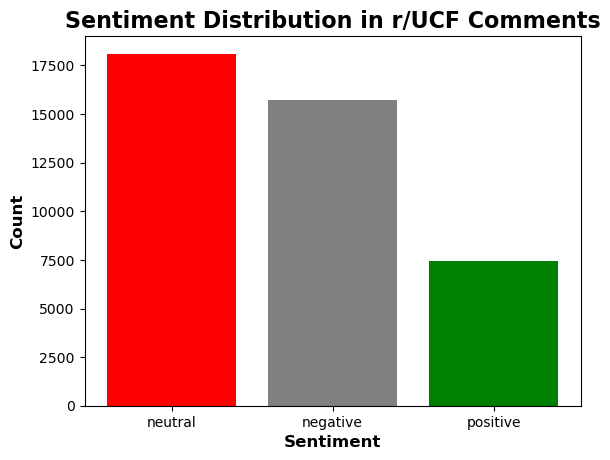

In [83]:
import matplotlib.pyplot as plt

counts = df["label"].value_counts()

plt.bar(counts.index, counts.values, color=["red", "gray", "green"])
plt.title("Sentiment Distribution in r/UCF Comments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [85]:
keywords = ["parking", "football", "housing", "professor", r"\bfriends?\b", r"\bpart(?:y|ies)\b" ] 
#friend or friends as well as party or parties

for kw in keywords:
    subset = df[df["text"].str.contains(kw, case=False, na=False)]
    if not subset.empty:
        print(f"\nTopic: {kw}")
        print(subset["label"].value_counts())
    else:
        print(f"\nTopic: {kw} → No matches found")



Topic: parking
label
negative    379
neutral     255
positive     61
Name: count, dtype: int64

Topic: football
label
negative    75
neutral     57
positive    28
Name: count, dtype: int64

Topic: housing
label
negative    59
neutral     38
positive    10
Name: count, dtype: int64

Topic: professor
label
negative    331
neutral     260
positive     92
Name: count, dtype: int64

Topic: \bfriends?\b
label
negative    249
neutral     174
positive    123
Name: count, dtype: int64

Topic: \bpart(?:y|ies)\b
label
negative    86
neutral     64
positive    28
Name: count, dtype: int64


In [87]:
import pandas as pd
import re

# -------- load & dedupe --------
CSV = "ucf_sentiment_master.csv"     # <-- change if your filename differs
df = pd.read_csv(CSV)

# robust dedupe (prefer comment_id if present)
dedupe_cols = [c for c in ["comment_id","text"] if c in df.columns]
df = df.drop_duplicates(subset=dedupe_cols, keep="first").reset_index(drop=True)

# -------- overall distribution --------
total = len(df)
order = ["negative","neutral","positive"]
counts = df["label"].value_counts().reindex(order).fillna(0).astype(int)
pct = (counts / total * 100).round(1)

print(f"TOTAL COMMENTS: {total}")
print("OVERALL COUNTS:", counts.to_dict())
print("OVERALL PCT   :", pct.to_dict())

# -------- topics (edit patterns as you like) --------
patterns = {
    "parking":       r"\b(?:parking|garage|permit|commute|commuting|commuter)\b",
    "housing":       r"\b(?:housing|apartment|apartments|lease|leasing|leased|rent|rental|renting|landlord|roommate|dorms?)\b",
    "football":      r"(?:\bfootball\b|\bknights\b|\bgame\s+day\b)",
    "professor(s)":  r"\bprofessors?\b",
    "friend(s)":     r"\bfriends?\b",
    "party/parties": r"\bpart(?:y|ies)\b",
}


rows = []
for name, pat in patterns.items():
    sub = df[df["text"].str.contains(pat, flags=re.I, na=False, regex=True)]
    n = len(sub)
    if n == 0:
        rows.append({"topic": name, "n": 0, "neg%": 0.0, "neu%": 0.0, "pos%": 0.0})
        continue
    c = sub["label"].value_counts()
    rows.append({
        "topic": name,
        "n": n,
        "neg%": round(100 * c.get("negative", 0) / n, 1),
        "neu%": round(100 * c.get("neutral", 0)  / n, 1),
        "pos%": round(100 * c.get("positive", 0) / n, 1),
    })

topic_df = pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)
topic_df


TOTAL COMMENTS: 41259
OVERALL COUNTS: {'negative': 15708, 'neutral': 18104, 'positive': 7447}
OVERALL PCT   : {'negative': 38.1, 'neutral': 43.9, 'positive': 18.0}


,topic,n,neg%,neu%,pos%
0,parking,893,51.0,39.0,10.1
1,professor(s),679,48.5,38.0,13.5
2,friend(s),546,45.6,31.9,22.5
3,housing,489,47.6,39.1,13.3
4,football,353,37.1,35.4,27.5
5,party/parties,178,48.3,36.0,15.7


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ---------- COLORS (UCF) ----------
UCF_GOLD  = "#B6862C"   # positive
UCF_BLACK = "#000000"   # negative
UCF_GRAY  = "#808080"   # neutral
LABEL_COLOR = {"negative": UCF_BLACK, "neutral": UCF_GRAY, "positive": UCF_GOLD}

# ---------- MATPLOTLIB TWEAKS ----------
plt.rcParams.update({
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# ---------- OVERALL DISTRIBUTION ----------
order = ["negative","neutral","positive"]
overall = df["label"].value_counts().reindex(order).fillna(0)

plt.figure()
bars = plt.bar(
    overall.index, overall.values,
    color=[LABEL_COLOR[l] for l in order],
    edgecolor="#222222", linewidth=1.2
)
# value labels on top
for b in bars:
    plt.text(
        b.get_x() + b.get_width()/2, b.get_height() * 1.01,
        f"{int(b.get_height()):,}", ha="center", va="bottom", fontweight="bold"
    )
plt.title("Overall Sentiment – r/UCF")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("overall_sentiment_ucf.png", dpi=240, bbox_inches="tight")
plt.close()

# ---------- TOPIC STACKED BAR ----------
# (rebuild topic table using your current `patterns` dict)
rows = []
for name, pat in patterns.items():
    sub = df[df["text"].str.contains(pat, flags=re.I, na=False, regex=True)]
    n = len(sub)
    c = sub["label"].value_counts()
    rows.append({
        "topic": name, "n": n,
        "neg": int(c.get("negative",0)),
        "neu": int(c.get("neutral",0)),
        "pos": int(c.get("positive",0)),
    })
topic_df = pd.DataFrame(rows).sort_values("n", ascending=False)

labels = topic_df["topic"].tolist()
neg = topic_df["neg"].to_numpy()
neu = topic_df["neu"].to_numpy()
pos = topic_df["pos"].to_numpy()

plt.figure()
plt.bar(labels, neg, label="Negative", color=LABEL_COLOR["negative"])
plt.bar(labels, neu, bottom=neg, label="Neutral",  color=LABEL_COLOR["neutral"])
plt.bar(labels, pos, bottom=neg+neu, label="Positive", color=LABEL_COLOR["positive"])
plt.title("Topic Sentiment – r/UCF")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.xticks(rotation=28, ha="right")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("topic_sentiment_stacked_ucf.png", dpi=240, bbox_inches="tight")
plt.close()

print("Saved: overall_sentiment_ucf.png, topic_sentiment_stacked_ucf.png")


Saved: overall_sentiment_ucf.png, topic_sentiment_stacked_ucf.png
